# Figures for DiffusionNet report

This notebook contains the code used to generate all the figures we used in the our report and presentation.  
It's divided into three parts

1. Agnosticity: We demonstrate the agnosticity of the architecture to the representation of the input data. We played around with one mesh by downsampling, resampling, and converting it into a point-cloud.
2. Diffusion and spectral decomposition: To illusrate the effect of diffusion, we show tok what extent it's able to propagate information on a surface.
3. Learned filters: One of the main claims of the DiffusionNet paper is that their architecture is able to learn filters which are more general than the radially symmetric ones.

**To run the first part of the notebook with no error, download and setup the human segmentation dataset as indicated in `experiments/human_segmentation_original/README.md`**

In [1]:
import os
import sys
import random
import multiprocessing
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import potpourri3d as pp
import pymeshlab
import trimesh
import meshplot as mp

import scipy.sparse as sparse


sys.path.append('src')  # add the path to the DiffusionNet src
import diffusion_net

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

device = 'cuda:0'
fig_save_dir = 'saved_figures'

def save_mesh(p, name):
    path = os.path.join(fig_save_dir, f'{name}.html')
    p.save(path)

## Agnosticity

### Utility functions

Several visuals of the paper (and the report) are based on a model trained for segmentation. To results consistent results with respect to the original paper, we use the checkpoints provided by the authors.

In [2]:
shading = {
    'colormap': 'jet', 
    'width': 300, 
    'height': 300
}

root_mesh = 'experiments/human_segmentation_original/data/sig17_seg_benchmark/meshes/test/shrec'
root_seg = 'experiments/human_segmentation_original/data/sig17_seg_benchmark/segs/test/shrec'
mesh_file = os.path.join(root_mesh, '4.off')
seg_file = os.path.join(root_seg, 'shrec_4_full.txt')

verts, faces = pp.read_mesh(mesh_file)
labels = np.loadtxt(seg_file).astype(int)-1
p = mp.plot(verts, faces, c=labels, shading=shading)
save_mesh(p, 'mesh_gt')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0249469…

Plot saved to file saved_figures/mesh_gt.html.


### Using the pretrained checkpoints on $xyz$ inputs 

In [3]:
ckpt_path = 'experiments/human_segmentation_original/pretrained_models/human_seg_xyz_4x128.pth'
    
model_mesh = diffusion_net.layers.DiffusionNet(C_in=3,
                                               C_out=8,
                                               C_width=128, 
                                               N_block=4, 
                                               last_activation=lambda x : torch.nn.functional.log_softmax(x,dim=-1),
                                               outputs_at='faces', 
                                               dropout=False)

model_vertices = diffusion_net.layers.DiffusionNet(C_in=3,
                                                   C_out=8,
                                                   C_width=128, 
                                                   N_block=4, 
                                                   last_activation=lambda x : torch.nn.functional.log_softmax(x,dim=-1),
                                                   outputs_at='vertices', 
                                                   dropout=False)

model_mesh = model_mesh.to(device)
model_mesh.load_state_dict(torch.load(ckpt_path, weights_only=False))
model_mesh.eval()

model_vertices = model_vertices.to(device)
model_vertices.load_state_dict(torch.load(ckpt_path, weights_only=False))
model_vertices.eval()

print('Models loaded')

Models loaded


### Running the model on the test sample 

We prepare the sample following the code of the dataset script

In [4]:
k_eig = 128
op_cache_dir = 'data/op_cache'

def compute_operators(verts, faces=None):
    curr_verts = verts.clone()
    if faces is not None:
        curr_faces = faces.clone()
        frames, mass, L, evals, evecs, gradX, gradY = diffusion_net.geometry.get_operators(curr_verts, curr_faces, k_eig=k_eig, op_cache_dir=op_cache_dir)
        return curr_verts, curr_faces, frames, mass, L, evals, evecs, gradX, gradY
    else:
        frames, mass, L, evals, evecs, gradX, gradY = diffusion_net.geometry.get_operators(curr_verts, torch.tensor([]), k_eig=k_eig, op_cache_dir=op_cache_dir)
        return curr_verts, frames, mass, L, evals, evecs, gradX, gradY
        
verts = torch.tensor(np.ascontiguousarray(verts)).float()
verts = diffusion_net.geometry.normalize_positions(verts)
faces = torch.tensor(np.ascontiguousarray(faces), dtype=torch.int64)

verts_pc, frames_pc, mass_pc, L_pc, evals_pc, evecs_pc, gradX_pc, gradY_pc = compute_operators(verts)

verts_pc = verts_pc.to(device)
frames_pc = frames_pc.to(device)
mass_pc = mass_pc.to(device)
L_pc = L_pc.to(device)
evals_pc = evals_pc.to(device)
evecs_pc = evecs_pc.to(device)
gradX_pc = gradX_pc.to(device)
gradY_pc = gradY_pc.to(device)

  cache miss -- constructing operators


src/diffusion_net/utils.py:55: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  return torch.sparse.FloatTensor(torch.LongTensor(indices), torch.FloatTensor(values), torch.Size(shape)).coalesce()


In [5]:
with torch.no_grad():
    preds = model_vertices(verts_pc, mass_pc, L=L_pc, evals=evals_pc, evecs=evecs_pc, gradX=gradX_pc, gradY=gradY_pc)
pred_labels_points = torch.max(preds, dim=1).indices

p = mp.plot(verts_pc.cpu().numpy(), c=pred_labels_points.cpu().numpy(), shading={'colormap': 'jet', 'point_size':0.09, 'width': 300, 'height': 300})
save_mesh(p, 'point_cloud_pred')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0256486…

Plot saved to file saved_figures/point_cloud_pred.html.


In [6]:
verts_mesh, faces_mesh, frames_mesh, mass_mesh, L_mesh, evals_mesh, evecs_mesh, gradX_mesh, gradY_mesh = compute_operators(verts, faces)

verts_mesh = verts_mesh.to(device)
faces_mesh = faces_mesh.to(device)
frames_mesh = frames_mesh.to(device)
mass_mesh = mass_mesh.to(device)
L_mesh = L_mesh.to(device)
evals_mesh = evals_mesh.to(device)
evecs_mesh = evecs_mesh.to(device)
gradX_mesh = gradX_mesh.to(device)
gradY_mesh = gradY_mesh.to(device)

with torch.no_grad():
    preds_mesh = model_mesh(verts_mesh, 
                            mass_mesh, 
                            L=L_mesh, 
                            evals=evals_mesh,
                            evecs=evecs_mesh, 
                            gradX=gradX_mesh, 
                            gradY=gradY_mesh, 
                            faces=faces_mesh
                           )
pred_labels_mesh = torch.max(preds_mesh, dim=1).indices

p = mp.plot(verts_mesh.cpu().numpy(), faces_mesh.cpu().numpy(), c=pred_labels_mesh.cpu().numpy(), shading=shading)
save_mesh(p, 'mesh_pred')

  cache miss -- constructing operators


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0256486…

Plot saved to file saved_figures/mesh_pred.html.


### Testing on a decimated version

In [7]:
n_faces = len(faces)

def decimate_mesh(verts, faces, targetfacenum=n_faces//10):
    ms = pymeshlab.MeshSet()
    ms.add_mesh(pymeshlab.Mesh(vertex_matrix=verts, face_matrix=faces))
    ms.meshing_decimation_quadric_edge_collapse(targetfacenum=targetfacenum)
    simplified_mesh = ms.current_mesh()
    simplified_verts = simplified_mesh.vertex_matrix()
    simplified_faces = simplified_mesh.face_matrix()
    return simplified_verts, simplified_faces

In [8]:
simplified_verts, simplified_faces = decimate_mesh(verts, faces)
simplified_verts = torch.tensor(np.ascontiguousarray(simplified_verts)).float()
simplified_verts = diffusion_net.geometry.normalize_positions(simplified_verts)
simplified_faces = torch.tensor(np.ascontiguousarray(simplified_faces), dtype=torch.int64)

verts_simple, faces_simple, frames_simple, mass_simple, L_simple, evals_simple, evecs_simple, gradX_simple, gradY_simple = compute_operators(simplified_verts, simplified_faces)

verts_simple = verts_simple.to(device)
faces_simple = faces_simple.to(device)
frames_simple = frames_simple.to(device)
mass_simple = mass_simple.to(device)
L_simple = L_simple.to(device)
evals_simple = evals_simple.to(device)
evecs_simple = evecs_simple.to(device)
gradX_simple = gradX_simple.to(device)
gradY_simple = gradY_simple.to(device)

preds = model_mesh(verts_simple, 
                   mass_simple, 
                   L=L_simple, 
                   evals=evals_simple, 
                   evecs=evecs_simple, 
                   gradX=gradX_simple, 
                   gradY=gradY_simple, 
                   faces=faces_simple
                  )
pred_labels_simple = torch.max(preds, dim=1).indices

p = mp.plot(verts_simple.cpu().numpy(), faces_simple.cpu().numpy(), c=pred_labels_simple.cpu().numpy(), shading=shading)
save_mesh(p, 'decimated_pred')

  cache miss -- constructing operators


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0033188…

Plot saved to file saved_figures/decimated_pred.html.


### Resampling

In [9]:
def resample_mesh(verts, faces, iterations=10):
    ms = pymeshlab.MeshSet()
    ms.add_mesh(pymeshlab.Mesh(vertex_matrix=verts, face_matrix=faces))

    ms.apply_coord_laplacian_smoothing(stepsmoothnum=iterations)
    smoothed_mesh = ms.current_mesh()
    smoothed_verts = smoothed_mesh.vertex_matrix()
    smoothed_faces = smoothed_mesh.face_matrix()

    return smoothed_verts, smoothed_faces

In [10]:
smoothed_verts, smoothed_faces = resample_mesh(verts.cpu(), faces.cpu(), iterations=10)
smoothed_verts = torch.tensor(np.ascontiguousarray(smoothed_verts)).float()
smoothed_verts = diffusion_net.geometry.normalize_positions(smoothed_verts)
smoothed_faces = torch.tensor(np.ascontiguousarray(smoothed_faces), dtype=torch.int64)

verts_smooth, faces_smooth, frames_smooth, mass_smooth, L_smooth, evals_smooth, evecs_smooth, gradX_smooth, gradY_smooth = compute_operators(smoothed_verts, smoothed_faces)

verts_smooth = verts_smooth.to(device)
faces_smooth = faces_smooth.to(device)
frames_smooth = frames_smooth.to(device)
mass_smooth = mass_smooth.to(device)
L_smooth = L_smooth.to(device)
evals_smooth = evals_smooth.to(device)
evecs_smooth = evecs_smooth.to(device)
gradX_smooth = gradX_smooth.to(device)
gradY_smooth = gradY_smooth.to(device)

preds = model_mesh(verts_smooth, 
                   mass_smooth, 
                   L=L_smooth, 
                   evals=evals_smooth, 
                   evecs=evecs_smooth, 
                   gradX=gradX_smooth, 
                   gradY=gradY_smooth, 
                   faces=faces_smooth
                  )
pred_labels_resample = torch.max(preds, dim=1).indices

p = mp.plot(verts_smooth.cpu().numpy(), faces_smooth.cpu().numpy(), c=pred_labels_resample.cpu().numpy(), shading=shading)
save_mesh(p, 'smooth_pred')

  cache miss -- constructing operators


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0246936…

Plot saved to file saved_figures/smooth_pred.html.


### Final plot 

In [11]:
shading = {'colormap': 'jet'}

verts = verts.numpy()
faces = faces.numpy()

verts_mesh = verts_mesh.cpu().numpy()
faces_mesh = faces_mesh.cpu().numpy()

verts_pc = verts_pc.cpu().numpy()

verts_simple = verts_simple.cpu().numpy()
faces_simple = faces_simple.cpu().numpy()

verts_smooth = verts_smooth.cpu().numpy()
faces_smooth = faces_smooth.cpu().numpy()

simplified_verts = simplified_verts.cpu().numpy()
simplified_faces = simplified_faces.cpu().numpy()

smoothed_verts = smoothed_verts.cpu().numpy()
smoothed_faces = smoothed_faces.cpu().numpy()

pred_labels_points = pred_labels_points.cpu().numpy()
pred_labels_simple = pred_labels_simple.cpu().numpy()
pred_labels_resample = pred_labels_resample.cpu().numpy()
pred_labels_mesh = pred_labels_mesh.cpu().numpy()

In [12]:
shift = np.array([0.9, 0.0, 0.0])
scale = 0.8

shading = {'colormap': 'jet', 'width': 1000, 'height': 500, 'point_size': 0.1}

mp.jupyter()
p = mp.plot(verts - 2 * shift, faces, c=labels, shading=shading, return_plot=True) #gt
p.add_mesh(verts_mesh - 1 * shift, faces_mesh, c=pred_labels_mesh, shading=shading) #pred mesh
p.add_points(verts_pc - 0 * shift, c=pred_labels_points, shading=shading) #pred points
p.add_mesh(scale * (verts_simple + 1 * shift) - np.array([0.0,0.15,0.0]), faces_simple, c=pred_labels_simple, shading=shading) #pred simple
p.add_mesh(verts_smooth + 2 * shift, faces_smooth, c=pred_labels_resample, shading=shading) #pred smooth
save_mesh(p, 'final_figure')

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

Plot saved to file saved_figures/final_figure.html.


### Plot learned spatial diffusion times

In [13]:
times = np.zeros((4, 128))
times[0] = next(iter(model_mesh.block_0.diffusion.parameters())).data.cpu().tolist()
times[1] = next(iter(model_mesh.block_1.diffusion.parameters())).data.cpu().tolist()
times[2] = next(iter(model_mesh.block_2.diffusion.parameters())).data.cpu().tolist()
times[3] = next(iter(model_mesh.block_3.diffusion.parameters())).data.cpu().tolist()
times.shape

(4, 128)

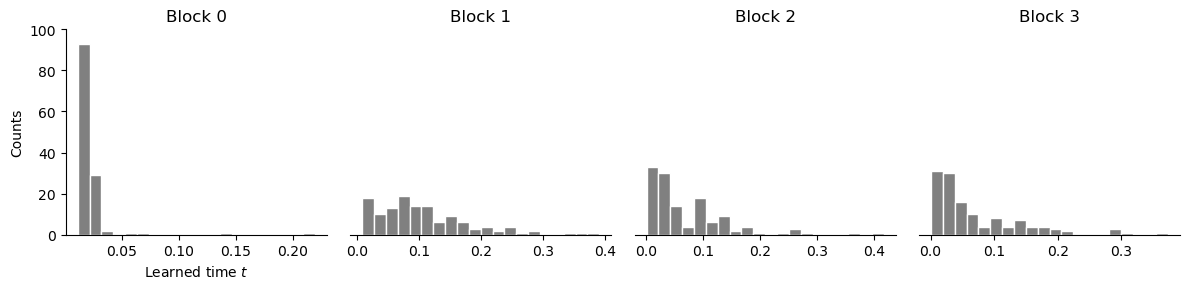

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
for i, time in enumerate(times):
    ax[i].hist(time, bins=20, edgecolor='white', color='gray')
    ax[i].set_ylim(0,100)
    ax[i].set_title(f'Block {i}')
    if i > 0:
        ax[i].get_yaxis().set_visible(False)
        ax[i].spines[['left']].set_visible(False)
ax[0].set_xlabel('Learned time $t$')
ax[0].set_ylabel('Counts')
plt.tight_layout()
plt.savefig(f'saved_figures/learned_times.png')

## Diffusion and Spectral decomposition

Here is the code used to generate the diffusion figure of the report.  
**This code is widely inspired from the practical sessions of the Geometry processing and geometric deep learning class of the MVA**.

In [15]:
# ===> Area matrix
def compute_faces_areas(vertices, faces):
    verts_faces = vertices[faces]
    v_1 = verts_faces[:, 0] - verts_faces[:, 1]
    v_2 = verts_faces[:, 0] - verts_faces[:, 2]
    n = np.cross(v_1, v_2)
    faces_areas = 0.5*np.linalg.norm(n, axis=-1)
    return faces_areas


def area_matrix(vertices, faces):    
    faces_areas = compute_faces_areas(vertices, faces)
    vertex_areas = np.zeros(vertices.shape[0])
    for idx, f in enumerate(faces):
        vertex_areas[f[0]] += faces_areas[idx]/3
        vertex_areas[f[1]] += faces_areas[idx]/3
        vertex_areas[f[2]] += faces_areas[idx]/3
    
    N = vertices.shape[0]
    A = sparse.dia_matrix((vertex_areas, 0), shape=(N, N))
    return A


# ===> cotan matrix
def cotan_weights(vertices, faces):
    verts_faces = vertices[faces]
    e_01 = verts_faces[:, 0] - verts_faces[:, 1]
    norm_01 = np.sqrt((e_01* e_01).sum(axis=-1))
    e_02 = verts_faces[:, 0] - verts_faces[:, 2]
    norm_02 = np.sqrt((e_02 * e_02).sum(axis=-1))
    e_12 = verts_faces[:, 1] - verts_faces[:, 2]
    norm_12 = np.sqrt((e_12 * e_12).sum(axis=-1))
    alpha_01 = np.arccos(np.abs((e_02 * e_12).sum(axis=-1))/(norm_02*norm_12))
    alpha_02 = np.arccos(np.abs((e_01 * e_12).sum(axis=-1))/(norm_01*norm_12))
    alpha_12 = np.arccos(np.abs((e_01 * e_02).sum(axis=-1))/(norm_01*norm_02))
    # This can be done in parallel using numpy, or by looping over the faces
    return np.concatenate((alpha_12[:, None], alpha_02[:, None], alpha_01[:, None]), axis=-1)

def cotan(x):
    ## Most of the time it's okay to use 1/np.tan, but remember that it doesn't work for x = pi/2
    return np.cos(x)/np.sin(x)

def cotan_matrix(vertices, faces):
    alphas = cotan_weights(vertices, faces)
    n_v = vertices.shape[0]
    list_I = []
    list_J = []
    list_V = []
    for idx_tup, (idx_1, idx_2) in enumerate([(1, 2), (2, 0), (0, 1)]):
        value = -0.5*cotan(alphas[:, idx_tup])
        list_I += [faces[:, idx_1], faces[:, idx_2], faces[:, idx_1], faces[:, idx_2]]
        list_J += [faces[:, idx_2], faces[:, idx_1], faces[:, idx_1], faces[:, idx_2]]
        list_V += [value, value, -value, -value]
    I = np.concatenate(list_I, axis=0)
    J = np.concatenate(list_J, axis=0)
    V = np.concatenate(list_V, axis=0)
    W = sparse.csc_matrix((V, (I, J)), shape=(n_v, n_v))
    return W


class Mesh:
    def __init__(self, path):
        self.vertices, self.faces = pp.read_mesh(path)
        
    def compute_laplacian(self):
        self.A = area_matrix(self.vertices, self.faces)
        self.W = cotan_matrix(self.vertices, self.faces)
        
    def compute_eigendecomposition(self, K):
        self.eigenvalues, self.eigenvectors = sparse.linalg.eigsh(self.W, M=self.A,
                                                                  k=K, sigma=-0.01)
        # The sigma parameter allows to stabilize the eigendecomposition

        
def diffuse_spectral(f, mesh, t, k):
    beta = (f[:, None] * (mesh.A @ mesh.eigenvectors[:, :k])).sum(axis=0)
    alpha = np.exp(-mesh.eigenvalues[:k]*t)*beta
    f_diffuse = ((mesh.eigenvectors[:, :k])*alpha[None, :]).sum(axis=-1)
    return f_diffuse

In [16]:
verts, faces = pp.read_mesh('experiments/human_segmentation_original/bunny.off')
shading = {
    'point_size':0.005, 
    'width': 300,
    'height': 300
}
p = mp.plot(verts, faces, shading=shading)
save_mesh(p, 'bunny_raw')
                                                
p = mp.plot(verts, c=0.1 * np.random.randn(len(verts)), shading=shading)
save_mesh(p, 'bunny_raw_pc')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_raw.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_raw_pc.html.


In [17]:
k_eig = 256
op_cache_dir = 'op_cache'
verts = torch.tensor(np.ascontiguousarray(verts)).float()
verts = diffusion_net.geometry.normalize_positions(verts)
faces = torch.tensor(np.ascontiguousarray(faces), dtype=torch.int64)

In [18]:
bunny = Mesh('experiments/human_segmentation_original/bunny.off')
bunny.compute_laplacian()
bunny.compute_eigendecomposition(k_eig)

shading = {
    'colormap': 'Reds',
    'width': 300,
    'height': 300
}

dirac = np.zeros(len(verts))
idx = 9
dirac[idx] = 1

p = mp.plot(bunny.vertices, bunny.faces, c=dirac, shading=shading)
save_mesh(p, 'bunny_diffuse_t0')

for t in [1e-5, 1e-4, 1e-3]:
    f_diffuse = diffuse_spectral(dirac, bunny, t, k_eig)
    p = mp.plot(bunny.vertices, bunny.faces, c=f_diffuse, shading=shading)
    save_mesh(p, f'bunny_diffuse_t{t}')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_diffuse_t0.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_diffuse_t1e-05.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_diffuse_t0.0001.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_diffuse_t0.001.html.


### Spectral decomposition 

In [19]:
shading = {
    'colormap': 'jet',
    'width': 300,
    'height': 300
}

proj = (dirac[:, None] * (bunny.A @ bunny.eigenvectors[:, :k_eig])).sum(axis=0)
rec = ((bunny.eigenvectors[:, :k_eig]) * proj[None, :]).sum(axis=-1)
p = mp.plot(bunny.vertices, bunny.faces, c=rec, shading=shading)
save_mesh(p, 'bunny_spectral_raw') 

for k in range(1, 150, 20):
    proj = (dirac[:, None] * (bunny.A @ bunny.eigenvectors[:, k].reshape(-1,1))).sum(axis=0)
    rec = ((bunny.eigenvectors[:, k].reshape(-1,1)) * proj[None, :]).sum(axis=-1)
    p = mp.plot(bunny.vertices, bunny.faces, c=rec, shading=shading)
    save_mesh(p, f'bunny_spectral_{k}')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_spectral_raw.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_spectral_1.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_spectral_21.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_spectral_41.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_spectral_61.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_spectral_81.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_spectral_101.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_spectral_121.html.


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Plot saved to file saved_figures/bunny_spectral_141.html.


## Learned filters

*Author: Géraud Ilinca (Télécom Paris)*

We visualize the filter learned by DiffusionNet blocks. However, the procedure below is based on sparse explanations provided in the legend of one of the figures.  
Although the results look visually convincing, there's no guarantee they correspond exactly to the results of the paper.  
For instance, the authors state that without gradient features, learned filters are only radially symmetric. But the obtained filters turn out to have a central symmetry, which is more general than expected. 

Just as in the article, we use a model trained on the human segmentation benchmark to output the learned filter.

### Load the model

We simply copy the training hypermeters defined for the human segmentation task.

In [20]:
device = torch.device('cuda:1')
dtype = torch.float32

n_class = 8
input_features = 'xyz'
C_in = {'xyz':3, 'hks':16}[input_features]
C_width = 128
N_block = 4

k_eig = 256

# training settings
train = False
n_epoch = 200
lr = 1e-3
decay_every = 50
decay_rate = 0.5
augment_random_rotate = (input_features == 'xyz')

cpkt_path = f'experiments/human_segmentation_original/pretrained_models/human_seg_xyz_4x128.pth'
op_cache_dir = 'op_cache/'

In [21]:
model_grad = diffusion_net.layers.DiffusionNet(C_in=C_in,
                                          C_out=n_class,
                                          C_width=C_width, 
                                          N_block=N_block, 
                                          last_activation=lambda x : torch.nn.functional.log_softmax(x,dim=-1),
                                          outputs_at='vertices', # manipulating point clouds
                                          dropout=False,
                                          with_gradient_features=True
                                         )

model_grad = model_grad.to(device)
model_grad.load_state_dict(torch.load(cpkt_path, device, weights_only=False))
print('Checkpoint loaded')

Checkpoint loaded


### Generate the grid

We define the square grid of with an odd number of vertices to be fed to the trained model. 

In [22]:
width = 41
size = 1 + 2*width

def generate_square_grid(size: int):
    """Returns verts (torch.Tensor(float))"""
    x = torch.linspace(-1, 1, steps=size)
    y = torch.linspace(-1, 1, steps=size)
    grid_x, grid_y = torch.meshgrid(x, y)
    verts = torch.stack([grid_x, grid_y, torch.zeros(grid_x.shape)]).T.reshape(-1, 3)
    return verts 

theta = np.pi / 4
Rx = torch.tensor([[1, 0, 0],[0, np.cos(theta), -np.sin(theta)],[0, np.sin(theta), np.cos(theta)]]).float()

verts = generate_square_grid(size)
print(verts.shape)
p = mp.plot((verts@Rx).detach().numpy(), c=np.random.randn(len(verts)) ,shading={'point_size': 0.2})
save_mesh(p, 'grid_raw')

torch.Size([6889, 3])


/home/infres/lmartinez-21/miniconda3/envs/diffusion_net/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_1455138/4280578089.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  verts = torch.stack([grid_x, grid_y, torch.zeros(grid_x.shape)]).T.reshape(-1, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Plot saved to file saved_figures/grid_raw.html.


In [23]:
verts = diffusion_net.geometry.normalize_positions(verts)
faces = torch.tensor([])
frames, massvec, L, evals, evecs, gradX, gradY = diffusion_net.geometry.get_operators(verts.cpu().detach(), 
                                                                                      faces, 
                                                                                      k_eig=k_eig, 
                                                                                      op_cache_dir=op_cache_dir
                                                                                     )

verts = verts.to(device)
mass = massvec.to(device)
L = L.to(device)
evals = evals.to(device)
evecs = evecs.to(device)
gradX = gradX.to(device)
gradY = gradY.to(device)

mass = mass.unsqueeze(0)
if L != None: L = L.unsqueeze(0)
if evals != None: evals = evals.unsqueeze(0)
if evecs != None: evecs = evecs.unsqueeze(0)
if gradX != None: gradX = gradX.unsqueeze(0)
if gradY != None: gradY = gradY.unsqueeze(0)

  cache miss -- constructing operators


### Gradient ascent on the grid with spatial gradient features

Objective: 9644.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 132.82it/s]


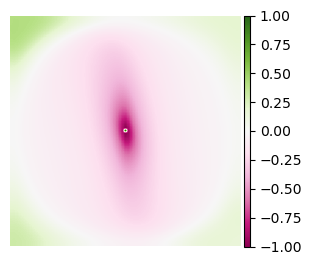

Filter saved to saved_figures/filter_with_grad_features_block_0_channel0.png


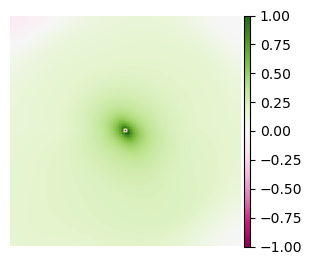

Filter saved to saved_figures/filter_with_grad_features_block_0_channel1.png


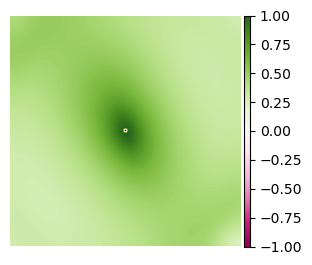

Filter saved to saved_figures/filter_with_grad_features_block_0_channel2.png


Objective: 5600.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 133.96it/s]


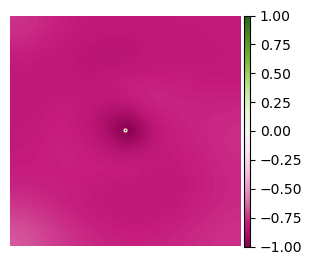

Filter saved to saved_figures/filter_with_grad_features_block_1_channel0.png


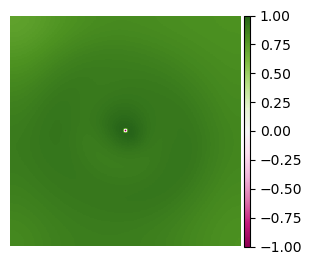

Filter saved to saved_figures/filter_with_grad_features_block_1_channel1.png


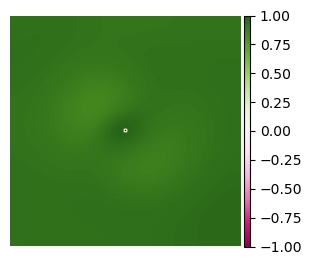

Filter saved to saved_figures/filter_with_grad_features_block_1_channel2.png


Objective: 4403.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.56it/s]


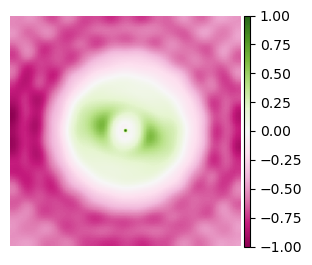

Filter saved to saved_figures/filter_with_grad_features_block_2_channel0.png


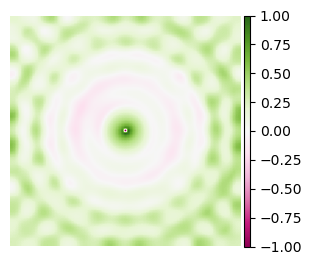

Filter saved to saved_figures/filter_with_grad_features_block_2_channel1.png


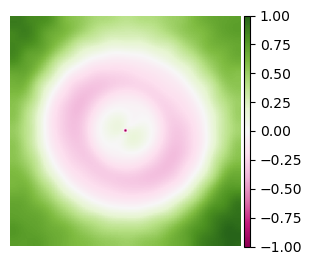

Filter saved to saved_figures/filter_with_grad_features_block_2_channel2.png


Objective: 7738.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.33it/s]


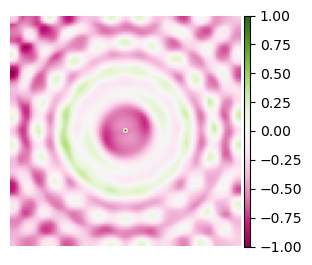

Filter saved to saved_figures/filter_with_grad_features_block_3_channel0.png


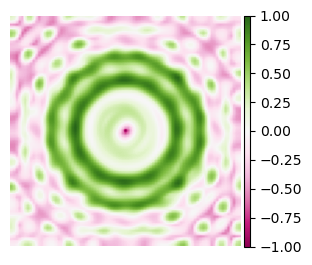

Filter saved to saved_figures/filter_with_grad_features_block_3_channel1.png


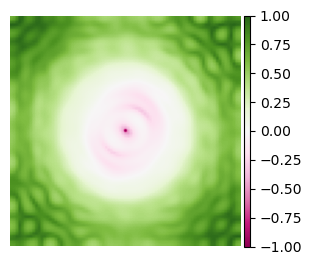

Filter saved to saved_figures/filter_with_grad_features_block_3_channel2.png


In [24]:
def show_filter(x_in, idx, name):
    x_res = x_in[0,:,idx]
    x_res = 2 * (x_res-x_res.min()) / (x_res.max()-x_res.min()) - 1

    fig = plt.figure(figsize=(3,3))
    ax = plt.axes()
    im = ax.imshow(x_res.reshape((size,size)).detach().cpu().numpy(), cmap="PiYG")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    ax.axis('off')
    plt.colorbar(im, cax=cax)
    
    save_path = f'{fig_save_dir}/{name}.png'
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    print(f'Filter saved to {save_path}')

def compute_filter(block_idx, num_iterations, model, lr):
    lin = model.first_lin
    block = model.blocks[block_idx]
    
    x_in = verts.clone().unsqueeze(0)
    x_in.requires_grad = True
    
    # Set up optimizer
    optimizer = optim.Adam([x_in], lr=lr)  # Learning rate can be adjusted
    
    objective_val = 0
    # Perform gradient ascent
    with tqdm(total=num_iterations) as pbar:
        for i in range(num_iterations):
            optimizer.zero_grad()  # Zero the gradients from the previous step
            x = lin(x_in)
            x = block(x, mass, L=L, evals=evals, evecs=evecs, gradX=gradX, gradY=gradY)  # Pass verts through the block
            objective = x[:, width * size + width, :].sum()  # Extract the value to maximize

            # Negate the loss since optimizers minimize by default, but we want to maximize
            # A renormalization at each step of x_in would be the best approach to stay normalized
            # Nevertheless, doing so x_in is no more leaf in the computational graph
            # Integrating the normalization into the loss leads to difficulty in convergence

            loss = -objective 
            loss.backward()  # Compute gradients with respect to x_in

            optimizer.step()  # Update x_in using the gradients
            objective_val = objective.item()
            pbar.set_description_str(f'Objective: {objective_val:.2f}') 
            pbar.update()
    return x_in.detach().clone().cpu()
            
    
# Block from which we want ot extract the learned filter
num_blocks = 4
num_channels = 3

# Number of iterations for gradient ascent
num_iterations = 5000

model_grad.eval()

for block_idx in range(num_blocks):
    learned_filter = compute_filter(block_idx, num_iterations, model_grad, lr=0.2)
    for channel_idx in range(num_channels):
        show_filter(learned_filter, channel_idx, f'filter_with_grad_features_block_{block_idx}_channel{channel_idx}')

### Gradient ascent on the grid without spatial gradient features 

The code provided with the paper doesn't allow to easily disable spatial gradient features when loading a pre-trained model from  

In [26]:
ckpt_path = 'experiments/human_segmentation_original/pretrained_models/human_seg_xyz_grad0_4x128.pth'

model_nograd = diffusion_net.layers.DiffusionNet(C_in=C_in,
                                                 C_out=n_class,
                                                 C_width=C_width, 
                                                 N_block=N_block, 
                                                 last_activation=lambda x : torch.nn.functional.log_softmax(x,dim=-1),
                                                 outputs_at='vertices', 
                                                 dropout=False,
                                                 with_gradient_features=False,
                                                 with_gradient_rotations=False
                                                )

model_nograd = model_nograd.to(device)
model_nograd.load_state_dict(torch.load(ckpt_path, weights_only=False))
print('Checkpoint loaded')

Checkpoint loaded


Objective: 10467.34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 357.62it/s]


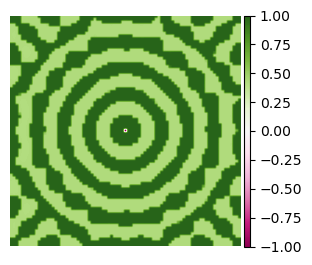

Filter saved to saved_figures/filter_no_grad_features_block_0_channel0.png


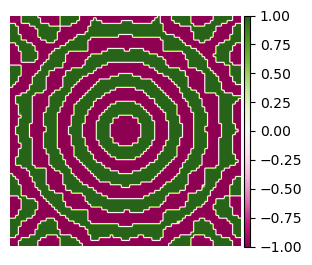

Filter saved to saved_figures/filter_no_grad_features_block_0_channel1.png


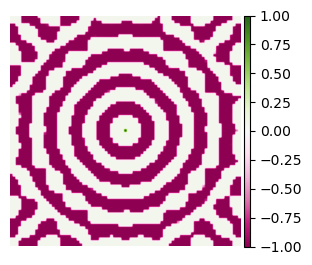

Filter saved to saved_figures/filter_no_grad_features_block_0_channel2.png


Objective: 10717.58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 292.33it/s]


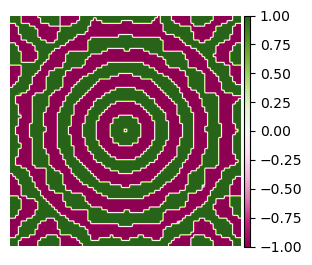

Filter saved to saved_figures/filter_no_grad_features_block_1_channel0.png


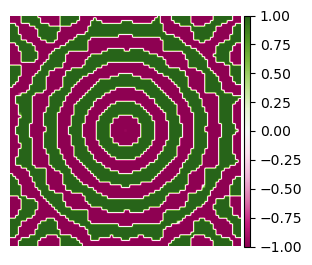

Filter saved to saved_figures/filter_no_grad_features_block_1_channel1.png


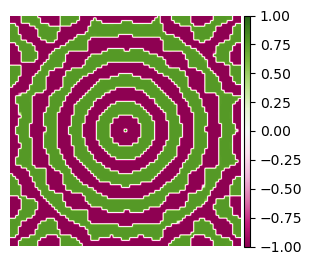

Filter saved to saved_figures/filter_no_grad_features_block_1_channel2.png


Objective: 10099.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 323.15it/s]


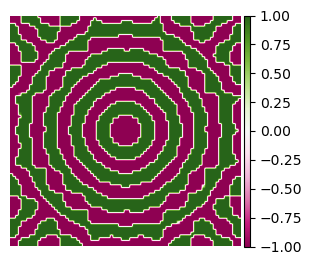

Filter saved to saved_figures/filter_no_grad_features_block_2_channel0.png


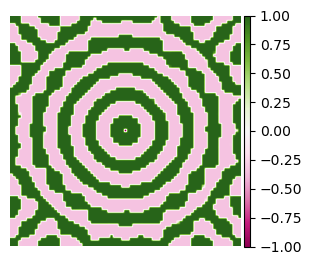

Filter saved to saved_figures/filter_no_grad_features_block_2_channel1.png


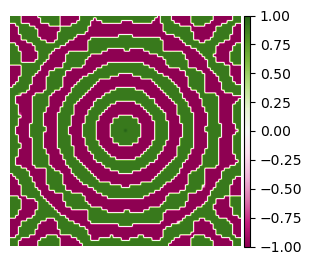

Filter saved to saved_figures/filter_no_grad_features_block_2_channel2.png


Objective: 11275.90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 268.70it/s]


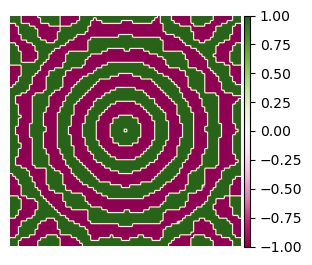

Filter saved to saved_figures/filter_no_grad_features_block_3_channel0.png


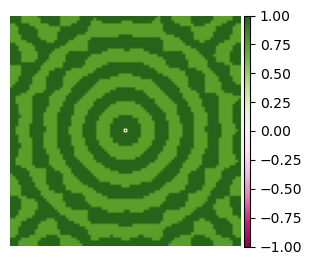

Filter saved to saved_figures/filter_no_grad_features_block_3_channel1.png


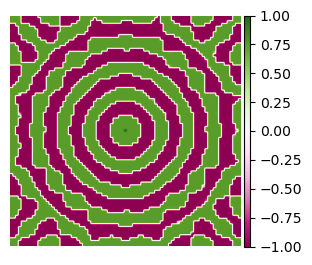

Filter saved to saved_figures/filter_no_grad_features_block_3_channel2.png


In [27]:
# Blocks from which we want ot extract the learned filter
num_blocks = 4
num_channels = 3

# Number of iterations for gradient ascent
num_iterations = 5000

model_nograd.eval()

for block_idx in range(num_blocks):
    learned_filter = compute_filter(block_idx, num_iterations, model_nograd, lr=0.2)
    for channel_idx in range(num_channels):
        show_filter(learned_filter, channel_idx, f'filter_no_grad_features_block_{block_idx}_channel{channel_idx}')
# compute_filter(block_idx, num_iterations, model_nograd)